In [13]:
#pip install pandahouse  # если библиотека ещё не установлена
import pandahouse as ph
import pandas as pd
import os 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

In [14]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [15]:
connection_test = dict(database='test',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student-rw',
                  password='656e2b0c9c')

In [16]:
plag= '''
    SELECT COUNT() FROM {db}.ldn_listings 
    '''
df = ph.read_clickhouse(plag, connection=connection_default)

In [17]:
df

,count()
0,85207


In [18]:
plag3= '''
    SELECT
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS pprice, 
    room_type 
    FROM {db}.ldn_listings
    ORDER BY id ASC 
    LIMIT 1000
    '''

In [19]:
df3 = ph.read_clickhouse(plag3, connection = connection_default)

In [20]:
df3.groupby('room_type').quantile(q=0.75)

,pprice
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


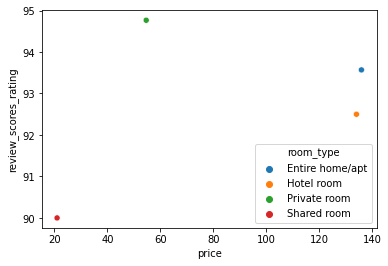

In [21]:
plag4 = ''' 
        SELECT 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        toFloat32OrNull(review_scores_rating) review_scores_rating,
        room_type
        FROM {db}.ldn_listings
        WHERE review_scores_rating is not null        
        ORDER BY id ASC
        LIMIT 1000
        '''
df4 = ph.read_clickhouse(plag4, connection = connection_default)
df4_1=df4.groupby('room_type', as_index=False).agg({'price' : 'mean', 'review_scores_rating' : 'mean'})
#при агрегации можно делать сразу 2 значения запомни
sns.scatterplot(data=df4_1, x='price', y='review_scores_rating', hue='room_type')

In [22]:
plag5 = ''' 
        SELECT 
        DISTINCT host_id,
                host_verifications
        FROM {db}.ldn_listings
        WHERE experiences_offered != 'none'
        '''
df5=ph.read_clickhouse(plag5, connection = connection_default)
df5.host_verifications = df5.host_verifications.apply(lambda x: x.strip('[]').split(', '))
#поскольку данные зписаны как одня строка нужно обработать столбец и воспользоватся лямда функациями
#strip чтобы удалить символами с начала и конца строки а split чтоб разделить строку по переданному разделению
#чтоб применить это ко всем строкам сразу воспользуемся функцией apply
df5.explode('host_verifications').value_counts('host_verifications')
#explode()- переводит из одной строки со списком в несколько строк с единственным значением

host_verifications
'phone'                    1361
'email'                    1345
'reviews'                  1309
'government_id'            1196
'jumio'                    1115
'offline_government_id'     469
'work_email'                279
'facebook'                  270
'selfie'                    252
'identity_manual'           227
'manual_offline'             70
'google'                     34
'kba'                        27
'manual_online'              16
'sent_id'                     6
dtype: int64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2595: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


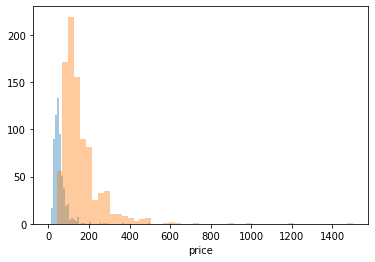

In [23]:
plag6 = '''
    SELECT 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        room_type
    FROM
        {db}.ldn_listings
    WHERE experiences_offered != 'none'   
        ''' 
df6=ph.read_clickhouse(plag6, connection = connection_default)
#без цикла фор 
sns.distplot(df6[df6.room_type == 'Private room'].price, kde= False)
sns.distplot(df6[df6.room_type == 'Entire home/apt'].price, kde= False)
sns.distplot(df6[df6.room_type == 'Hotel  room'].price, kde= False)

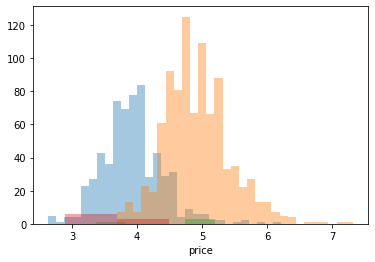

In [24]:
#с циклом фор
for room in df6.room_type.unique():
    sns.distplot(np.log(df6[df6.room_type == room].price), kde= False)

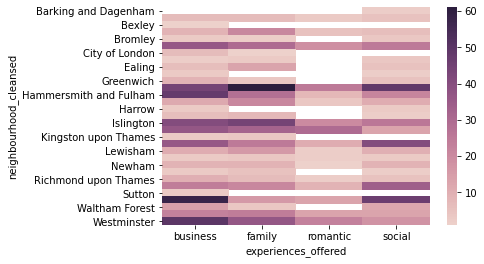

In [35]:
plag7=  '''
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(*) AS experiences_count
FROM 
    {db}.ldn_listings
WHERE 
    experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
        '''
df7=ph.read_clickhouse(plag7, connection = connection_default)
df_pivot = df7.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
sns.heatmap(df_pivot, cmap=sns.cubehelix_palette(as_cmap=True))